### 1. Import packages

In [1]:
import numpy as np
import pandas as pd
import anndata
import datatable as dt
import scanpy as sc
import pickle
from sklearn.metrics.cluster import adjusted_rand_score

import WEST_plt

file_path = '/home/stat/cai/WEST/data/cancer/'

/home/stat/anaconda3/envs/deepst_env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 2. Load data

In [2]:
#### Read data from pickle
with open(file_path+'raw_data.pkl', 'rb') as file:
    adata = pickle.load(file)

### 3. Environment setting

In [3]:
import sys 
import os
sys.path.append("/home/stat/cai/WEST/code/DeepST/DeepST-main/deepst")
os.chdir('/home/stat/cai/WEST/code/DeepST/DeepST-main/deepst')
from DeepST import run

deepen = run(save_path = '/home/stat/cai/WEST/code',
	task = "Identify_Domain", #### DeepST includes two tasks, one is "Identify_Domain" and the other is "Integration"
	pre_epochs = 800, ####  choose the number of training
	epochs = 1000, #### choose the number of training
	use_gpu = True)


### 4. Preprocess

In [4]:
adata.obsm['spatial'] = adata.obs[['loc_x', 'loc_y']].to_numpy()
adata = deepen._get_augment(adata, spatial_type="NearestNeighbors", use_morphological=False)

graph_dict = deepen._get_graph(adata.obsm["spatial"], distType = "BallTree")
data = deepen._data_process(adata, pca_n_comps = 200)

Physical distance calculting Done!
The number of nearest tie neighbors in physical distance is: 30.0
Gene correlation calculting Done!
The weight result of image feature is added to adata.obsm['weights_matrix_all'] !


Find adjacent spots of each spot: 100%|██████████ [ time left: 00:00 ]

Step 1: Augment molecule expression is Done!
12.0000 neighbors per cell on average.



/home/stat/anaconda3/envs/deepst_env/lib/python3.9/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


Step 2: Graph computing is Done!


### 5. Model training

In [5]:
###### Training models
deepst_embed = deepen._fit(
		data = data,
		graph_dict = graph_dict,)


Your task is in full swing, please wait


DeepST trains an initial model: 100%|██████████ [ time left: 00:00 ]
DeepST trains a final model:   0%|           [ time left: ? ]/home/stat/anaconda3/envs/deepst_env/lib/python3.9/site-packages/torch/nn/functional.py:2916: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(
DeepST trains a final model: |           [ time left: 00:00 ]    

Step 3: DeepST training has been Done!
Current memory usage：2.5032 GB
Total time: 1.12 minutes
Your task has been completed, thank you
Of course, you can also perform downstream analysis on the processed data


### 6. Clustering

In [6]:
###### DeepST outputs
adata.obsm["DeepST_embed"] = deepst_embed

###### Define the number of space domains, and the model can also be customized. If it is a model custom priori = False.
adata = deepen._get_cluster_data(adata, n_domains=4, priori = True)

ARI = adjusted_rand_score(adata.obs['DeepST_refine_domain'], adata.obs['true cluster']) # ARI of the cluster result only use gene expression
print('ARI: ', ARI)
print(adata.obs['DeepST_refine_domain'].unique())

Best resolution:  0.4099999999999998
ARI:  0.6653391444113264
['1' '0' '2' '3']


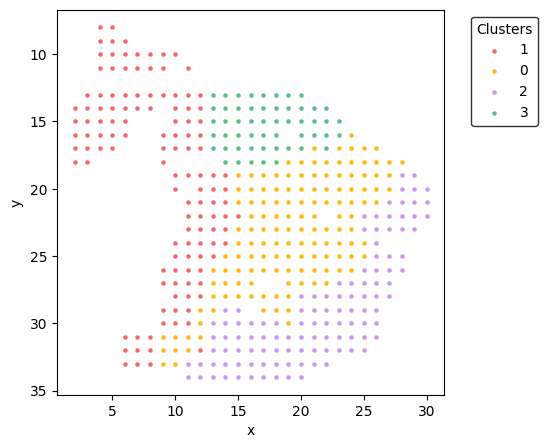

In [7]:
WEST_plt.WEST_scatter(adata, reps='DeepST_refine_domain', invert_y=True, s=5)

### 7. Save embedding

In [8]:
np.savetxt(file_path+'DeepST_embedding.csv', adata.obsm['DeepST_embed'], delimiter=',')
np.savetxt(file_path+'DeepST_cluster.csv', adata.obs['DeepST_refine_domain'], delimiter=',', fmt='%s')